In [1]:
import sys
sys.path.append('../')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from helpers_mom6.collection_of_experiments import CollectionOfExperiments
from helpers.plot_helpers import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [2]:
folder = '/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-SGS-KE-Sadourny-div/SGS-KE'
ds = xr.open_mfdataset(f'{folder}/snapshots*', decode_times=False)
param = xr.open_dataset(f'{folder}/ocean_geometry.nc')

In [3]:
def KEz(ds):
    return 0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl')

In [55]:
def log10KEz(ds):
    return np.log10(0.5 * (ds.h * (remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h))).sum('zl'))

In [56]:
def plot(var, **kw):
    var.plot.imshow(interpolation='none', **kw)
    plt.gca().axes.set_aspect('equal')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    lons = [10,30,50]
    plt.xticks(lons, [f'${lon}$'+'$^{\circ}$E' for lon in lons])
    lats = [-60, -40, -20, 0, 20, 40, 60]
    lat_ticks = [f'${-lat}$'+'$^{\circ}$S' if lat<0 else f'${lat}$'+'$^{\circ}$N' for lat in lats]
    plt.yticks(lats, lat_ticks)

In [57]:
def plot_KEz(dds, **kw):
    plot(log10KEz(dds), cmap='inferno', vmin=-1, vmax=3, **kw)

(-70.0, -20.0)

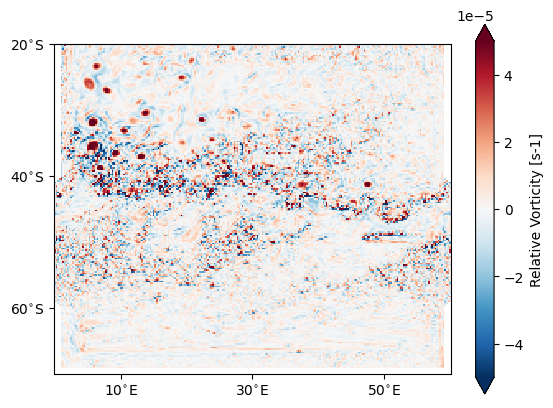

In [58]:
plot(ds.RV.isel(time=88,zl=0),vmax=5e-5)
plt.ylim([-70,-20])

In [59]:
SGS_KE = np.maximum(ds.SGS_KE,0.0)+1e-30
SGS_KE_est = np.maximum(- ds.h * (ds.Txx + ds.Tyy) * 0.5, 0.0)+1e-30

def plotter(idx=0):
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plot_KEz(ds.isel(time=idx), add_colorbar=False)
    plt.ylim([-70,-0])
    plt.title('Resolved KE')
    
    plt.subplot(1,3,2)
    plot(np.log10(SGS_KE.sum('zl')).isel(time=idx), cmap='inferno', vmin=-1, vmax=3, add_colorbar=False)
    plt.ylim([-70,-0])
    plt.title('Simulated SGS KE')
    
    plt.subplot(1,3,3)
    plot(np.log10(SGS_KE_est.sum('zl')).isel(time=idx), cmap='inferno', vmin=-1, vmax=3, add_colorbar=False)
    plt.ylim([-70,-0])
    plt.title('Estimated SGS KE')
    

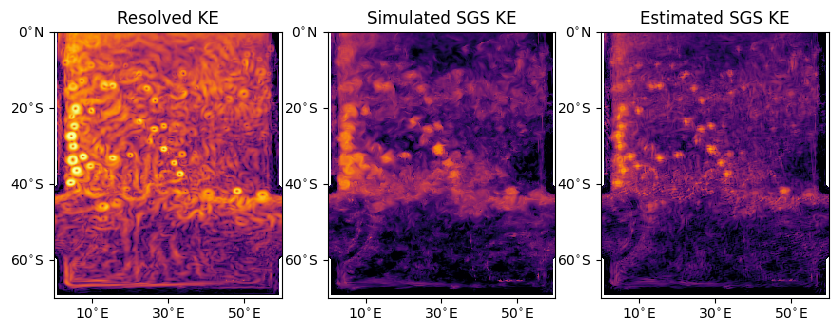

In [60]:
plotter()

In [400]:
create_animation_ffmpeg(plotter, range(200), dpi=150, filename='SGS_KE.mp4')

Frames already exists in folder .ffmpeg/SGS_KE
Do you want to update snapshots?: [y/n]y
Native resolution of snapshots is used: 1256x494

Animation SGS_KE.mp4 at FPS=18 will last for 11.1 seconds. The frames are saved to 
.ffmpeg/SGS_KE



ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

# Isotropic part of the stress tensor generates eddies?

In [61]:
from dask import delayed
folder = '/scratch/pp2681/mom6/Neverworld2/simulations/R4-ANN/CM26_grid_harmonic_ver3-SGS-KE-Sadourny-div/SGS-KE'
ds = xr.open_mfdataset(f'{folder}/snapshots*', decode_times=False, chunks={'zl':1, 'zi':1, 'time':1}).drop_vars(['u', 'v', 'h']).rename({'u_ZB': 'u', 'v_ZB': 'v', 'h_ZB': 'h'}).isel(time=0).load()
param = xr.open_dataset(f'{folder}/ocean_geometry.nc').rename({'lonq': 'xq', 'latq': 'yq', 'lonh': 'xh', 'lath': 'yh'})
static = xr.open_dataset(f'{folder}/static.nc', decode_times=False).squeeze().drop_vars('time')
param = xr.merge([param, static])

In [62]:
ds

<xarray.Dataset>
Dimensions:     (xq: 241, yh: 560, zl: 15, xh: 240, yq: 561, zi: 16)
Coordinates:
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
    time        float64 2.505e+03
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables: (12/18)
    u           (zl, yh, xq) float32 nan nan nan nan nan ... nan nan nan nan nan
    v           (zl, yq, xh) float32 nan nan nan nan nan ... nan nan nan nan nan
    h           (zl, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan nan
    e           (zi, yh, xh) float64 nan nan nan nan nan ... nan nan nan nan nan
    RV          (zl, yq, xq) float32 nan nan nan nan nan ... nan nan nan nan nan
    diffu       (zl, yh, xq) float32 nan nan nan nan nan ... nan nan nan nan nan
    ...          ...
    Txy_smag    (zl, yq, xq) float32 nan nan nan nan nan ... nan nan nan nan nan
    Txx         (zl, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan nan
    Tyy         (zl, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan nan
    Txy         (zl, yq, xq) float32 nan nan nan nan nan ... nan nan nan nan nan
    visc_coef   (zl, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan nan
    SGS_KE      (zl, yh, xh) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    filename:          snapshots_00002505.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [120]:
from xgcm import Grid
def compute(mom, param):
    grid = Grid(param, coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'}
        },
        boundary={'X':'periodic', 'Y':'fill'},
        fill_value = {'X':1e+20, 'Y':1e+20}
        )
    dudx = grid.diff(mom.u * param.wet_u / param.dyCu, 'X') * param.dyT / param.dxT
    dvdy = grid.diff(mom.v * param.wet_v / param.dxCv, 'Y') * param.dxT / param.dyT
    
    dudy = grid.diff(mom.u / param.dxCu, 'Y') * param.dxBu / param.dyBu * param.wet_c
    dvdx = grid.diff(mom.v / param.dyCv, 'X') * param.dyBu / param.dxBu * param.wet_c
    
    div_xx = dudx + dvdy
    sh_xx = dudx-dvdy
    sh_xy = dvdx+dudy
    
    h_u = grid.interp(mom.h * param.wet, 'X')
    h_v = grid.interp(mom.h * param.wet, 'Y')

    from xgcm.grid_ufunc import as_grid_ufunc
    @as_grid_ufunc(signature="(X:center)->(X:outer)", boundary_width={'X':(1,1)})
    def prod_ufunc(a):
        return a[...,:-1] * a[...,1:]
    
    h2uq = 4.0 * prod_ufunc(grid, h_u, axis='Y')
    h2vq = 4.0 * prod_ufunc(grid, h_v, axis='X')
    h_neglect3 = 1e-70
    hq = (2 * h2uq * h2vq) / (h_neglect3 + (h2uq+h2vq) * 2 * (grid.interp(h_u,'Y') + grid.interp(h_v,'X')))

    
    Txx = mom.Txx - mom.Txx_smag
    Tyy = mom.Tyy + mom.Txx_smag
    Txy = mom.Txy - mom.Txy_smag
    Tdd = 0.5 * (Txx - Tyy)
    Ttr = 0.5 * (Txx + Tyy)
    Esource_ZB =  mom.h * param.area_t * (Tdd * sh_xx + Ttr * div_xx) + grid.interp(hq * param.area_q * Txy * sh_xy, ['X', 'Y'])
    Esource_div =  mom.h * param.area_t * (Ttr * div_xx)

    Esource_smag =  mom.h * param.area_t * (mom.Txx_smag * sh_xx) + grid.interp(hq * param.area_q * mom.Txy_smag * sh_xy, ['X', 'Y'])
    
    Tdd = 0.5 * (mom.Txx - mom.Tyy)
    Ttr = 0.5 * (mom.Txx + mom.Tyy)
    Txy = mom.Txy
    Esource = mom.h * param.area_t * (Tdd * sh_xx + Ttr * div_xx) + grid.interp(hq * param.area_q * Txy * sh_xy, ['X', 'Y'])
    return {'div_xx': div_xx, 'Esource': Esource, 'Esource_div': Esource_div, 'Esource_smag': Esource_smag, 'Esource_ZB': Esource_ZB}

(-40.0, -20.0)

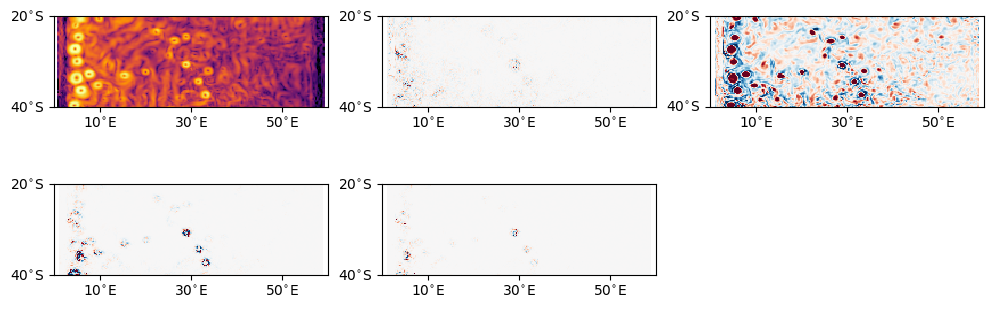

In [121]:
plt.figure(figsize=(12,4))
plt.subplot(2,3,1)
plot_KEz(ds, add_colorbar=False)
plt.ylim([-40,-20])

plt.subplot(2,3,2)
plot(compute(ds, param)['div_xx'].isel(zl=2), vmax=2e-5, add_colorbar=False)
plt.ylim([-40,-20])

plt.subplot(2,3,3)
plot(ds.RV.isel(zl=2), vmax=2e-5, add_colorbar=False)
plt.ylim([-40,-20])

plt.subplot(2,3,4)
plot(compute(ds, param)['Esource_ZB'].isel(zl=2), vmax=1e+5, add_colorbar=False)
plt.ylim([-40,-20])

plt.subplot(2,3,5)
plot(compute(ds, param)['Esource_div'].isel(zl=2), vmax=1e+5, add_colorbar=False)
plt.ylim([-40,-20])

# According to the numbers below, ANN on average dissipates energy. It is in contrast to Double Gyre case, where it was backscattering on average. Also, divergence on average also dissipates energy. As compared to Double Gyre, where Smagorinsky was equilibrating ANN, here they both work in the same direciton.

In [122]:
compute(ds, param)['Esource'].sum()

<xarray.DataArray ()>
array(2.66985842e+08)
Coordinates:
    time     float64 2.505e+03

In [123]:
compute(ds, param)['Esource_smag'].sum()

<xarray.DataArray ()>
array(1.85591474e+08)
Coordinates:
    time     float64 2.505e+03

In [124]:
compute(ds, param)['Esource_ZB'].sum()

<xarray.DataArray ()>
array(81394367.89888456)
Coordinates:
    time     float64 2.505e+03

In [125]:
compute(ds, param)['Esource_div'].sum()

<xarray.DataArray ()>
array(49357771.16754295)
Coordinates:
    time     float64 2.505e+03

In [126]:
compute(ds, param)['Esource_div'].sum() / compute(ds, param)['Esource_ZB'].sum()

<xarray.DataArray ()>
array(0.60640278)
Coordinates:
    time     float64 2.505e+03

In [128]:
compute(ds, param)['Esource_ZB'].sum() + compute(ds, param)['Esource_smag'].sum()

<xarray.DataArray ()>
array(2.66985842e+08)
Coordinates:
    time     float64 2.505e+03

# Major problem - SGS KE linearly grows with time

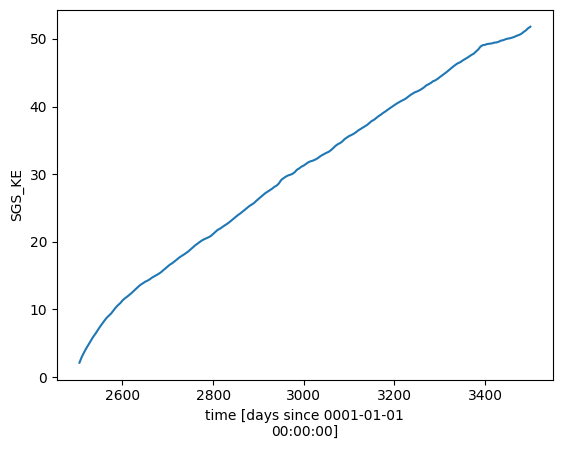

In [360]:
ds.SGS_KE.mean(['xh', 'yh']).sum('zl').plot()

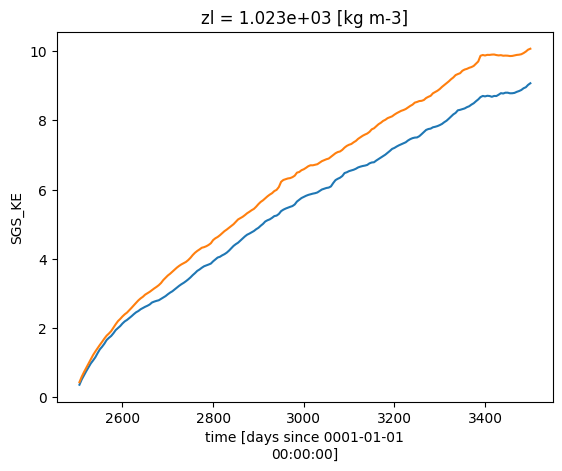

In [365]:
ds.SGS_KE.mean(['xh', 'yh']).isel(zl=0).plot()
ds.SGS_KE.mean(['xh', 'yh']).isel(zl=2).plot()

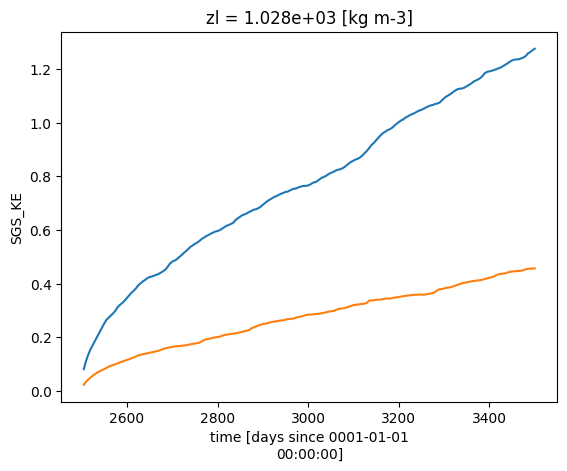

In [366]:
ds.SGS_KE.mean(['xh', 'yh']).isel(zl=5).plot()
ds.SGS_KE.mean(['xh', 'yh']).isel(zl=-1).plot()

In [375]:
KE = (0.5 * ds.h * remesh(ds.u**2, ds.h) + remesh(ds.v**2, ds.h)).mean(['xh', 'yh'])

(0.0, 1.6518846690654754)

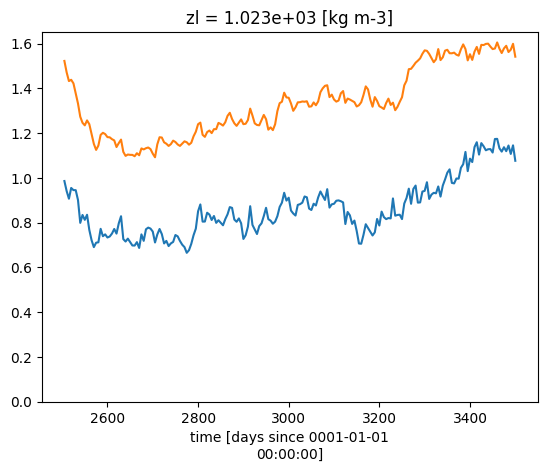

In [376]:
KE.isel(zl=0).plot()
KE.isel(zl=2).plot()

plt.ylim([0,None])

(0.0, 0.8901036310940981)

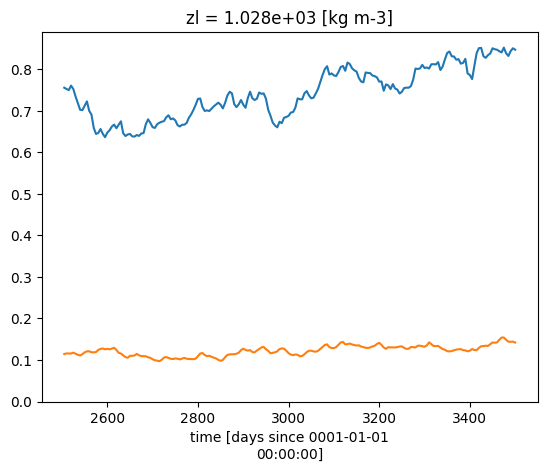

In [377]:
KE.isel(zl=5).plot()
KE.isel(zl=-1).plot()

plt.ylim([0,None])

# Thickness-averaged equation

In [5]:
# prog = xr.open_mfdataset(
#     '/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-SGS-KE-div-averaged-repeat/upwind/prog__*.nc', 
#     decode_times=False)

In [23]:
mom_upwind = xr.open_mfdataset(
    '/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-SGS-KE-div-averaged-repeat/upwind/mom__*.nc', 
    decode_times=False)

mom_SL = xr.open_mfdataset(
    '/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-SGS-KE-div-averaged-repeat/semi-lagrangian/mom__*.nc', 
    decode_times=False)

In [35]:
(mom_upwind.SGS_KE).hvplot(x='xh', y='yh', width=400, height=400, title='Upwind layer-integrated SGS KE') + (mom_SL.SGS_KE).hvplot(x='xh', y='yh', width=400, height=400, title='Semi-lagrangian layer-integrated SGS KE')

:Layout
   .DynamicMap.I  :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (SGS_KE)
   .DynamicMap.II :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (SGS_KE)

In [28]:
mom_upwind.Esource_adv.hvplot(x='xh', y='yh', width=400, height=400) + mom_SL.Esource_adv.hvplot(x='xh', y='yh', width=400, height=400)

:Layout
   .DynamicMap.I  :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (Esource_adv)
   .DynamicMap.II :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (Esource_adv)

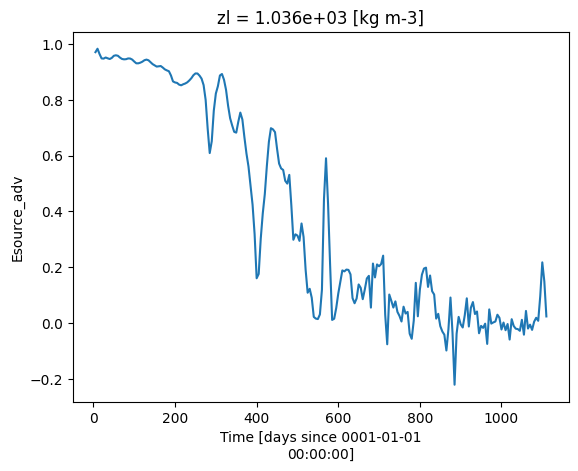

In [31]:
xr.corr(mom_upwind.Esource_adv, mom_SL.Esource_adv, ['xh', 'yh']).isel(zl=1).plot()

In [11]:
param = xr.open_mfdataset(
    '/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4/ZB-1.0-SGS-KE-div-averaged-repeat/upwind/ocean_geometry.nc', 
    decode_times=False).rename({'lath': 'yh', 'lonh': 'xh'})

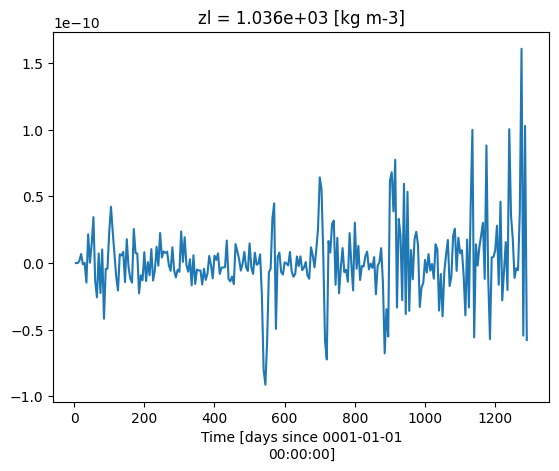

In [21]:
normalization = (mom.Esource_adv.std(['xh', 'yh', 'zl']).isel(Time=-1) * param.dxT * param.dyT).sum(['xh', 'yh'])
((mom.Esource_adv * param.dxT * param.dyT).sum(['xh', 'yh']).isel(zl=1) / normalization).plot()

# Energy analysis in Double Gyre

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/CM26_Double_Gyre/generalization/ANN_CM26_grid_harmonic_ver3-R4', additional_subfolder='output')
exp = ds['ZB-1.0-SGS-KE-div-diag']
exp_upwind = ds['ZB-1.0-SGS-KE-div-upwind']
exp_upwind_collocated = ds['ZB-1.0-SGS-KE-div-upwind-time-collocated']
exp_diss = ds['ZB-1.0-SGS-KE-div-upwind-time-collocated-diss']
exp_fct = ds['ZB-1.0-FCT']
exp_fct_1 = ds['ZB-1.0-FCT-1']
exp_fct_2 = ds['ZB-1.0-FCT-2']

In [7]:
ds.exps

['ZB-1.0-Conserv',
 'ZB-1.0-Cs-0.0',
 'ZB-1.0-Cs-0.06',
 'ZB-1.0-FCT',
 'ZB-1.0-GM-Conserv',
 'ZB-1.0-GM-Conserv-bound',
 'ZB-1.0-SGS-KE',
 'ZB-1.0-SGS-KE-2160.0',
 'ZB-1.0-SGS-KE-540.0',
 'ZB-1.0-SGS-KE-HSU',
 'ZB-1.0-SGS-KE-HSU-trace-free',
 'ZB-1.0-SGS-KE-bound-Coriolis',
 'ZB-1.0-SGS-KE-div',
 'ZB-1.0-SGS-KE-div-averaged',
 'ZB-1.0-SGS-KE-div-diag',
 'ZB-1.0-SGS-KE-div-upwind',
 'ZB-1.0-SGS-KE-div-upwind-time-collocated',
 'ZB-1.0-SGS-KE-div-upwind-time-collocated-diss',
 'ZB-1.0-SGS-KE-trace-free',
 'ZB-1.0-ratio-0.9',
 'ZB-1.0-ratio-1.0',
 'ZB-1.0-ratio-1.1',
 'ZB-2.0-Cs-0.0',
 'ZB-2.0-Cs-0.06']

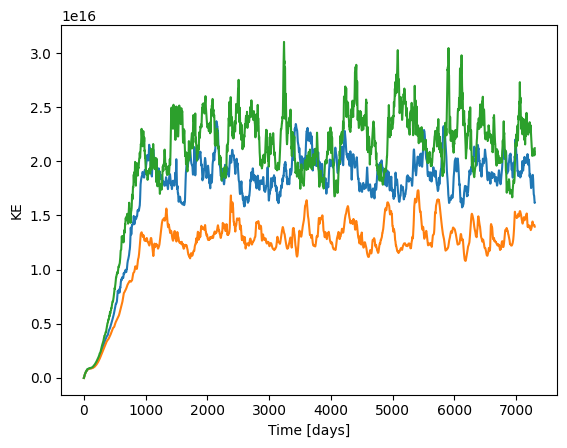

In [10]:
#exp.series.KE.sum('Layer').plot()
#exp_upwind.series.KE.sum('Layer').plot()
exp_upwind_collocated.series.KE.sum('Layer').plot()
exp_diss.series.KE.sum('Layer').plot()
exp_fct.series.KE.sum('Layer').plot()

In [42]:
SGS_KE = np.maximum(exp.mom.SGS_KE, 0.0) + 1e-30
SGS_KE_est = np.maximum((exp.mom.Txx + \
              exp.mom.Tyy) * \
              exp.h * (-0.5), 0.0) + 1e-30

In [43]:
Esource_smag = exp.mom.Esource_smag
Esource_ZB = exp.mom.Esource_ZB
Esource_adv = exp.mom.Esource_adv

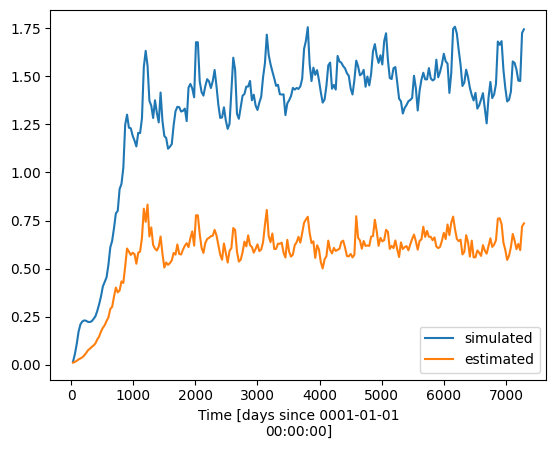

In [44]:
SGS_KE.mean(['xh','yh']).sum('zl').plot(label='simulated')
SGS_KE_est.mean(['xh','yh']).sum('zl').plot(label='estimated')
plt.legend()

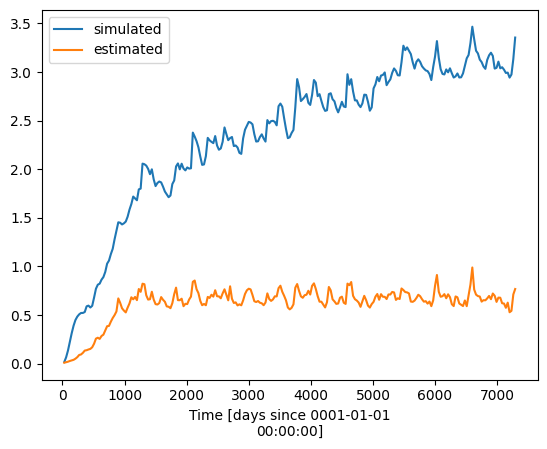

In [68]:
SGS_KE = np.maximum(exp_upwind.mom.SGS_KE, 0.0) + 1e-30
SGS_KE_est = np.maximum((exp_upwind.mom.Txx + \
              exp_upwind.mom.Tyy) * \
              exp_upwind.h * (-0.5), 0.0) + 1e-30

SGS_KE.mean(['xh','yh']).sum('zl').plot(label='simulated')
SGS_KE_est.mean(['xh','yh']).sum('zl').plot(label='estimated')
plt.legend()

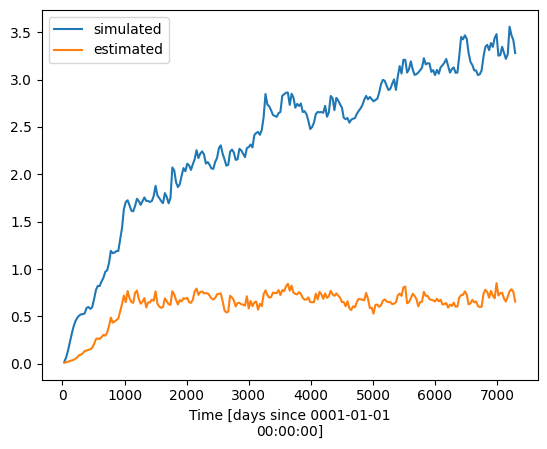

In [69]:
SGS_KE = np.maximum(exp_upwind_collocated.mom.SGS_KE, 0.0) + 1e-30
SGS_KE_est = np.maximum((exp_upwind_collocated.mom.Txx + \
              exp_upwind_collocated.mom.Tyy) * \
              exp_upwind_collocated.h * (-0.5), 0.0) + 1e-30

SGS_KE.mean(['xh','yh']).sum('zl').plot(label='simulated')
SGS_KE_est.mean(['xh','yh']).sum('zl').plot(label='estimated')
plt.legend()

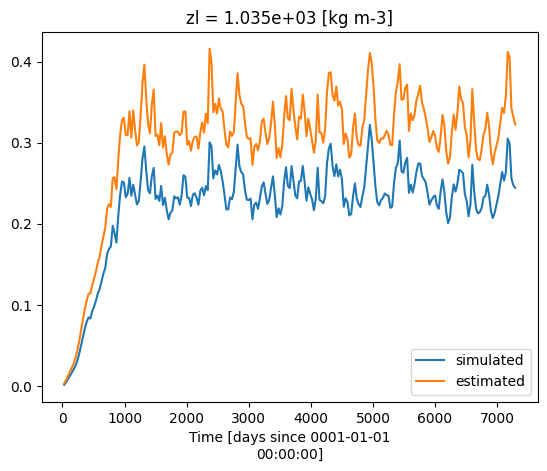

In [28]:
SGS_KE = np.maximum(exp_diss.mom.SGS_KE, 0.0) + 1e-30
SGS_KE_est = np.maximum((exp_diss.mom.Txx + \
              exp_diss.mom.Tyy) * \
              exp_diss.h * (-0.5), 0.0) + 1e-30

SGS_KE.mean(['xh','yh']).isel(zl=0).plot(label='simulated')
SGS_KE_est.mean(['xh','yh']).isel(zl=0).plot(label='estimated')
plt.legend()

In [11]:
expp = exp_fct

KE = expp.KE * expp.h

Esource_smag = expp.mom.Esource_smag
Esource_ZB = expp.mom.Esource_ZB
try:
    Esource_dis = expp.mom.Esource_dis
except:
    Esource_dis = Esource_ZB * 0

# SGS_KE = np.maximum(expp.mom.SGS_KE, 0.0) + 1e-30
# SGS_KE_est = np.maximum((expp.mom.Txx + \
#               expp.mom.Tyy) * \
#               expp.h * (-0.5), 0.0) + 1e-30

In [12]:
import cmocean

In [15]:
def plotter(idx=0):
    plt.figure(figsize=(14,9))
    plt.subplot(2,3,1)
    np.log10(KE.sum('zl')).isel(Time=idx).plot(vmax=3, vmin=-1, cmap='inferno', add_colorbar=False)
    plt.title('Resolved KE')
    plt.gca().axes.set_aspect('equal')
    
#     plt.subplot(2,3,2)
#     np.log10(SGS_KE.sum('zl')).isel(Time=idx).plot(vmax=3, vmin=-1, cmap='inferno', add_colorbar=False)
#     plt.title('Simulated SGS KE')
#     plt.gca().axes.set_aspect('equal')
    
#     plt.subplot(2,3,3)
#     np.log10(SGS_KE_est.sum('zl')).isel(Time=idx).plot(vmax=3, vmin=-1, cmap='inferno', add_colorbar=False)
#     plt.title('Estimated SGS KE')
#     plt.gca().axes.set_aspect('equal')
    
    plt.subplot(2,3,4)
    Esource_ZB.sum('zl').isel(Time=idx).plot(vmin=-3e-5, vmax = 3e-5, add_colorbar=False, cmap=cmocean.cm.balance)
    plt.gca().axes.set_aspect('equal')
    plt.title('SGS KE Source \nby ANN')
    
    plt.subplot(2,3,5)
    Esource_smag.sum('zl').isel(Time=idx).plot(vmin=-3e-5, vmax = 3e-5, add_colorbar=False, cmap=cmocean.cm.balance)
    plt.gca().axes.set_aspect('equal')
    plt.title('SGS KE Source \nby Smagorinsky')
    
    plt.subplot(2,3,6)
    (Esource_smag + Esource_ZB).sum('zl').isel(Time=idx).plot(vmin=-3e-5, vmax = 3e-5, add_colorbar=False, cmap=cmocean.cm.balance)
    plt.gca().axes.set_aspect('equal')
    plt.title('SGS KE Source \nby ANN+Smagorinsky')

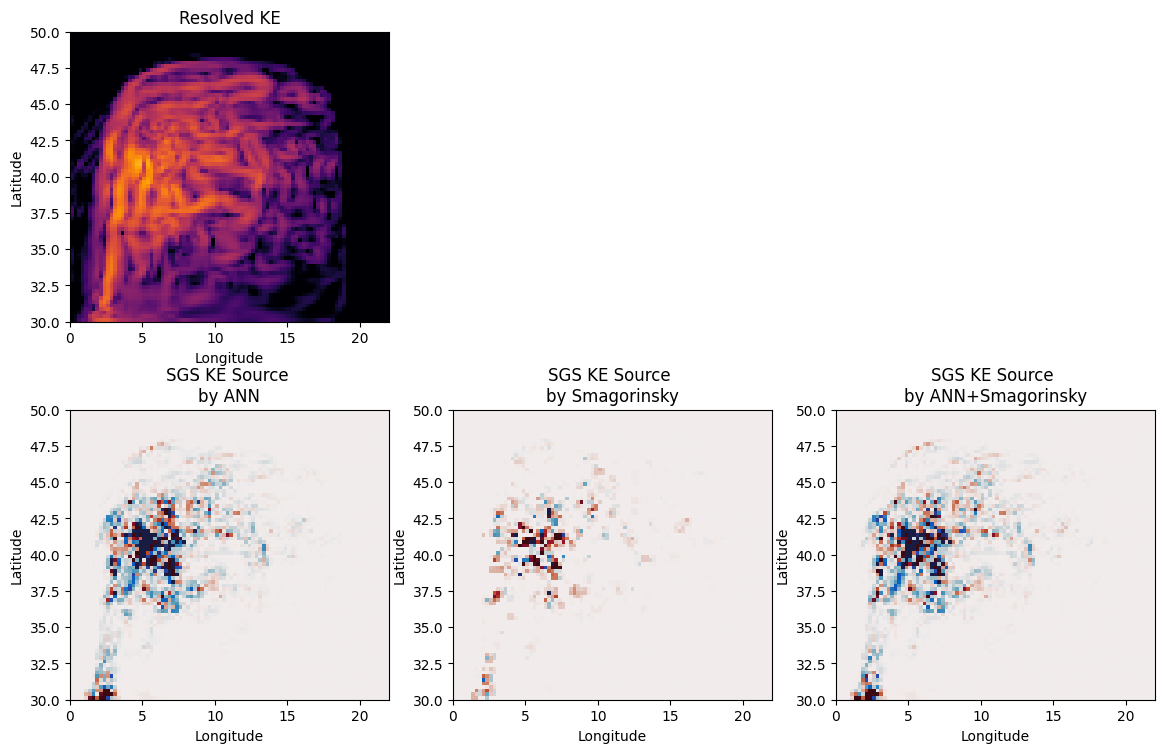

In [19]:
plotter(-100)

In [20]:
create_animation_ffmpeg(plotter, range(243), dpi=150, filename='SGS_KE_DG_FCT.mp4')

Native resolution of snapshots is used: 1746x1126

Animation SGS_KE_DG_FCT.mp4 at FPS=18 will last for 13.5 seconds. The frames are saved to 
.ffmpeg/SGS_KE_DG_FCT



ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

# Accuracy of ernergy source computation has relative error 1e-9

In [111]:
KE_tendency_exact = (exp.mom.KE_ZB2020 * exp.param.dxT * exp.param.dyT).sum(['zl', 'xh', 'yh'])

In [112]:
KE_tendency = - ((exp.mom.Esource_ZB + exp.mom.Esource_smag) * exp.param.dxT * exp.param.dyT).sum(['zl', 'xh', 'yh'])

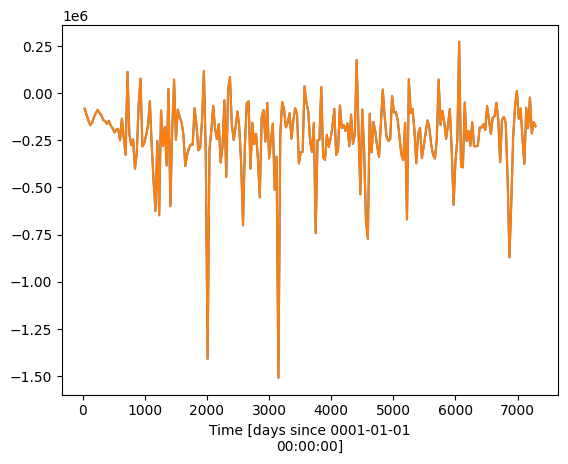

In [113]:
KE_tendency_exact.plot()
KE_tendency.plot()

In [118]:
((KE_tendency-KE_tendency_exact) / KE_tendency).values

array([ 1.16371903e-08, -8.07285537e-09,  2.08236985e-09, -1.28743625e-08,
        8.86734091e-09, -1.17627777e-08, -2.63313384e-09, -5.09260382e-08,
        1.03524058e-08, -1.25924255e-08, -5.01775534e-09,  1.74101057e-08,
        3.36170749e-08, -9.24526681e-09,  1.92351979e-08, -4.07890247e-08,
       -1.16881557e-09, -3.55683538e-08,  2.72509852e-08, -2.88611954e-10,
       -1.16382265e-08,  1.25088498e-08,  2.78774193e-08,  4.42059175e-08,
       -4.79333337e-10,  4.76145769e-08, -4.92620495e-08,  3.29177816e-08,
       -6.92857637e-08,  1.87629612e-07,  7.56731345e-08, -3.23726735e-08,
       -5.00290235e-08,  1.70659717e-08, -1.30286719e-08,  1.57349053e-07,
        8.26110759e-08, -5.28951495e-08, -6.18297888e-08, -6.72417598e-08,
        9.35536534e-09,  1.37072184e-07,  3.47450277e-08, -4.90965041e-08,
        2.87756915e-09,  4.41104419e-07, -9.37753470e-09,  3.52657674e-08,
       -2.38226903e-07, -4.78496727e-08,  4.17888964e-08, -4.09442819e-08,
       -9.02169486e-08,  

# Energy sources in SGS KE equation

In [55]:
ANN_source = ((exp.mom.Esource_ZB) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Smag_source = ((exp.mom.Esource_smag) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Adv_source = ((exp.mom.Esource_adv) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])

Text(0.5, 1.0, 'Lower Layer')

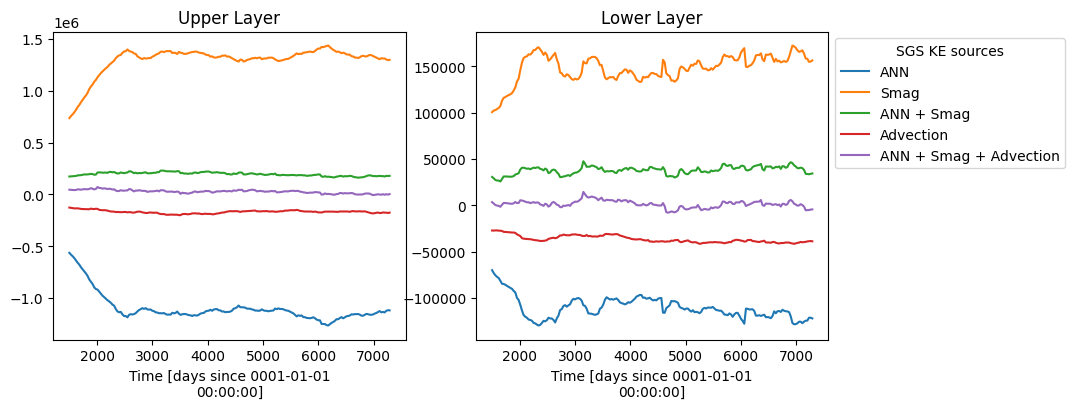

In [56]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ANN_source.isel(zl=0).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=0).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).rolling(Time=50).mean().isel(zl=0).plot(label='ANN + Smag')
(Adv_source).isel(zl=0).rolling(Time=50).mean().plot(label='Advection')
(ANN_source + Smag_source + Adv_source).isel(zl=0).rolling(Time=50).mean().plot(label='ANN + Smag + Advection')
plt.title('Upper Layer')

plt.subplot(1,2,2)
ANN_source.isel(zl=1).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=1).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag')
(Adv_source).isel(zl=1).rolling(Time=50).mean().plot(label='Advection')
(ANN_source + Smag_source + Adv_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag + Advection')
plt.legend(title='SGS KE sources', bbox_to_anchor=(1,1))
plt.title('Lower Layer')

In [67]:
ANN_source = ((exp_upwind.mom.Esource_ZB) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Smag_source = ((exp_upwind.mom.Esource_smag) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Adv_source = ((exp_upwind.mom.Esource_adv) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])

Text(0.5, 1.0, 'Lower Layer')

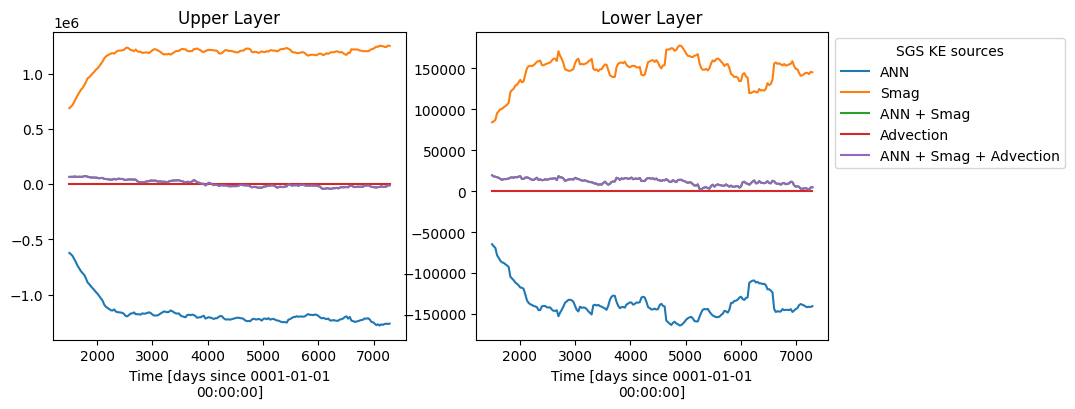

In [68]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ANN_source.isel(zl=0).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=0).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).rolling(Time=50).mean().isel(zl=0).plot(label='ANN + Smag')
(Adv_source).isel(zl=0).rolling(Time=50).mean().plot(label='Advection')
(ANN_source + Smag_source + Adv_source).isel(zl=0).rolling(Time=50).mean().plot(label='ANN + Smag + Advection')
plt.title('Upper Layer')

plt.subplot(1,2,2)
ANN_source.isel(zl=1).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=1).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag')
(Adv_source).isel(zl=1).rolling(Time=50).mean().plot(label='Advection')
(ANN_source + Smag_source + Adv_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag + Advection')
plt.legend(title='SGS KE sources', bbox_to_anchor=(1,1))
plt.title('Lower Layer')

In [78]:
ANN_source = ((exp_upwind_collocated.mom.Esource_ZB) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
ANN_source_plus = ((np.maximum(exp_upwind_collocated.mom.Esource_ZB, 0.0)) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
ANN_source_minus = ((np.minimum(exp_upwind_collocated.mom.Esource_ZB, 0.0)) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Smag_source = ((exp_upwind_collocated.mom.Esource_smag) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Adv_source = ((exp_upwind_collocated.mom.Esource_adv) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])

Text(0.5, 1.0, 'Lower Layer')

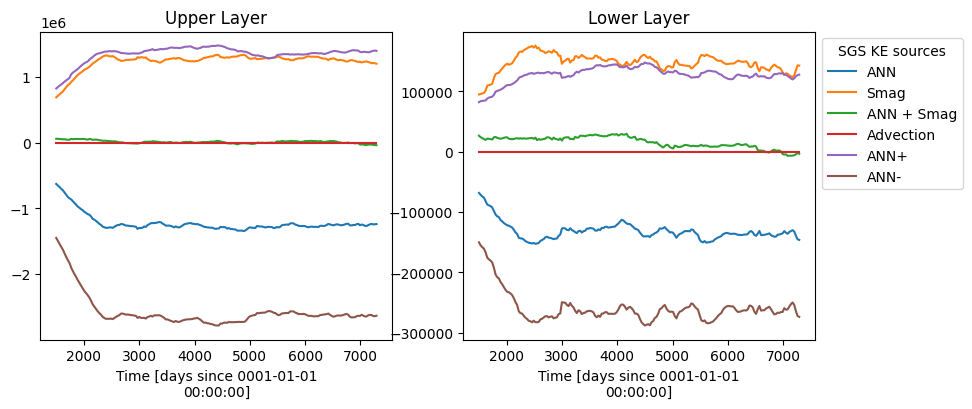

In [79]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ANN_source.isel(zl=0).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=0).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).rolling(Time=50).mean().isel(zl=0).plot(label='ANN + Smag')
(Adv_source).isel(zl=0).rolling(Time=50).mean().plot(label='Advection')
ANN_source_plus.isel(zl=0).rolling(Time=50).mean().plot(label='ANN+')
ANN_source_minus.isel(zl=0).rolling(Time=50).mean().plot(label='ANN-')
#(ANN_source + Smag_source + Adv_source).isel(zl=0).rolling(Time=50).mean().plot(label='ANN + Smag + Advection')
plt.title('Upper Layer')

plt.subplot(1,2,2)
ANN_source.isel(zl=1).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=1).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag')
(Adv_source).isel(zl=1).rolling(Time=50).mean().plot(label='Advection')
ANN_source_plus.isel(zl=1).rolling(Time=50).mean().plot(label='ANN+')
ANN_source_minus.isel(zl=1).rolling(Time=50).mean().plot(label='ANN-')
#(ANN_source + Smag_source + Adv_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag + Advection')
plt.legend(title='SGS KE sources', bbox_to_anchor=(1,1))
plt.title('Lower Layer')

In [33]:
ANN_source = ((exp_diss.mom.Esource_ZB) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Smag_source = ((exp_diss.mom.Esource_smag) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Adv_source = ((exp_diss.mom.Esource_adv) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Dis_source = ((exp_diss.mom.Esource_dis) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])

Text(0.5, 1.0, 'Lower Layer')

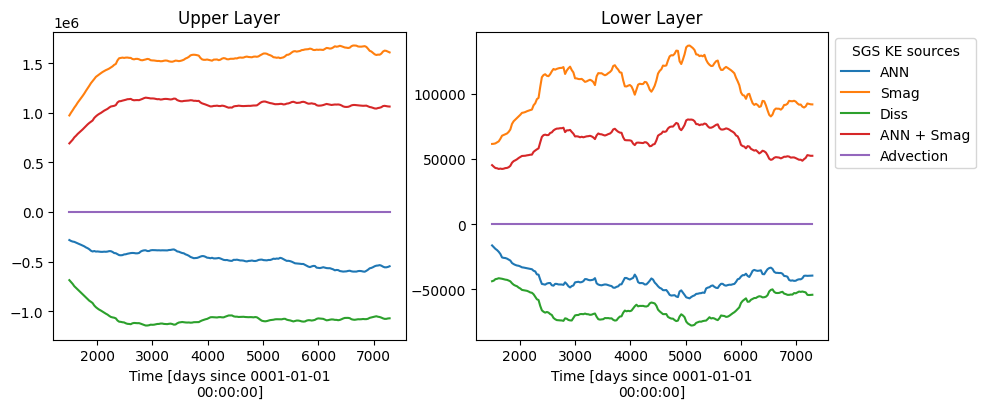

In [34]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ANN_source.isel(zl=0).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=0).rolling(Time=50).mean().plot(label='Smag')
Dis_source.isel(zl=0).rolling(Time=50).mean().plot(label='Diss')
(Smag_source + ANN_source).rolling(Time=50).mean().isel(zl=0).plot(label='ANN + Smag')
(Adv_source).isel(zl=0).rolling(Time=50).mean().plot(label='Advection')
#(ANN_source + Smag_source + Adv_source).isel(zl=0).rolling(Time=50).mean().plot(label='ANN + Smag + Advection')
plt.title('Upper Layer')

plt.subplot(1,2,2)
ANN_source.isel(zl=1).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=1).rolling(Time=50).mean().plot(label='Smag')
Dis_source.isel(zl=1).rolling(Time=50).mean().plot(label='Diss')
(Smag_source + ANN_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag')
(Adv_source).isel(zl=1).rolling(Time=50).mean().plot(label='Advection')
#(ANN_source + Smag_source + Adv_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag + Advection')
plt.legend(title='SGS KE sources', bbox_to_anchor=(1,1))
plt.title('Lower Layer')

In [21]:
ANN_source = ((exp_fct.mom.Esource_ZB) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Smag_source = ((exp_fct.mom.Esource_smag) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])

Text(0.5, 1.0, 'Lower Layer')

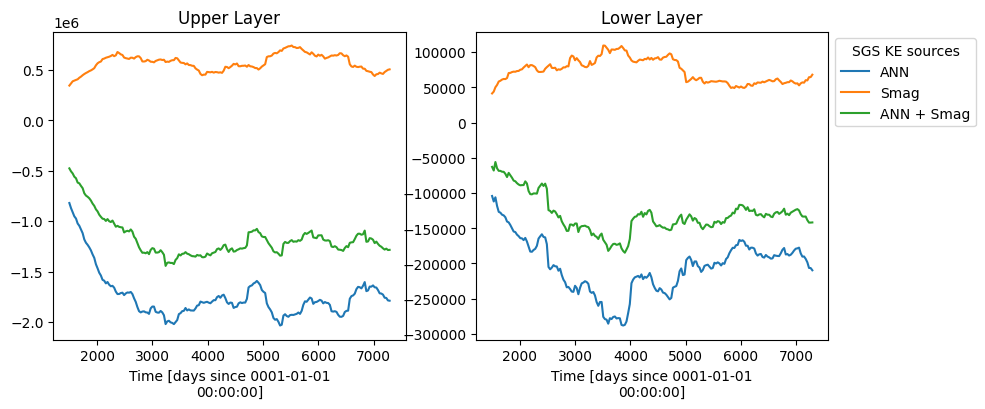

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ANN_source.isel(zl=0).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=0).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).rolling(Time=50).mean().isel(zl=0).plot(label='ANN + Smag')
plt.title('Upper Layer')

plt.subplot(1,2,2)
ANN_source.isel(zl=1).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=1).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag')
plt.legend(title='SGS KE sources', bbox_to_anchor=(1,1))
plt.title('Lower Layer')

In [12]:
ANN_source = ((exp_fct_1.mom.Esource_ZB) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Smag_source = ((exp_fct_1.mom.Esource_smag) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])

Text(0.5, 1.0, 'Lower Layer')

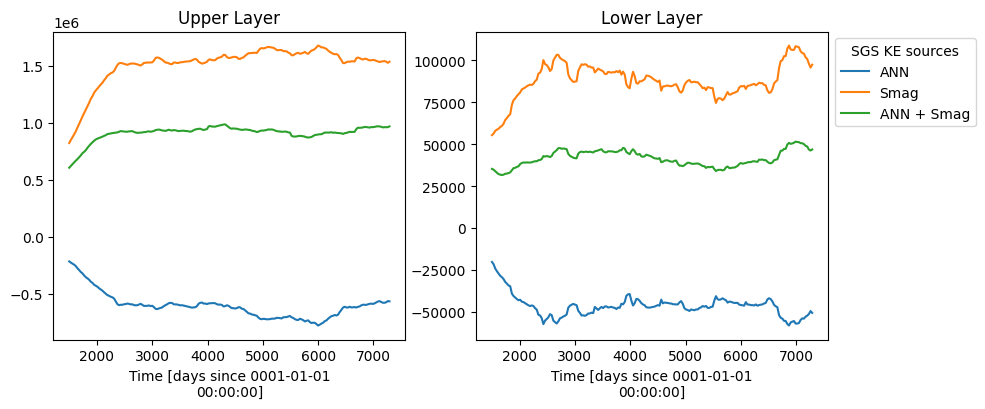

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ANN_source.isel(zl=0).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=0).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).rolling(Time=50).mean().isel(zl=0).plot(label='ANN + Smag')
plt.title('Upper Layer')

plt.subplot(1,2,2)
ANN_source.isel(zl=1).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=1).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag')
plt.legend(title='SGS KE sources', bbox_to_anchor=(1,1))
plt.title('Lower Layer')

In [15]:
ANN_source = ((exp_fct_2.mom.Esource_ZB) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])
Smag_source = ((exp_fct_2.mom.Esource_smag) * exp.param.dxT * exp.param.dyT).sum(['xh', 'yh'])

Text(0.5, 1.0, 'Lower Layer')

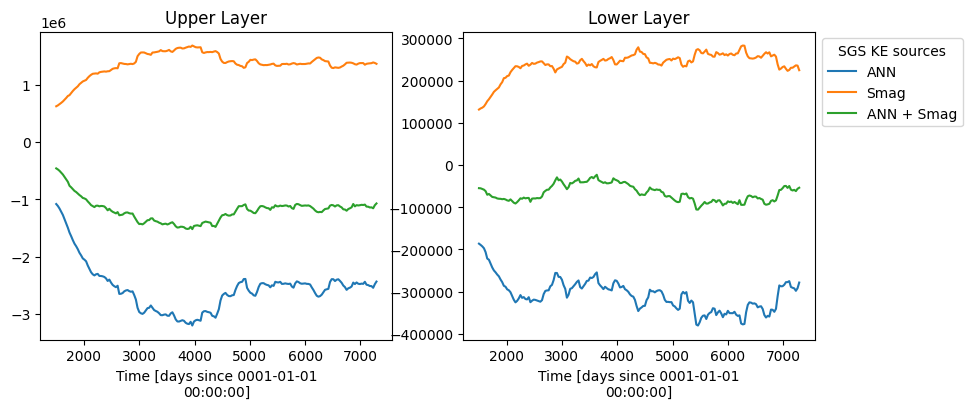

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ANN_source.isel(zl=0).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=0).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).rolling(Time=50).mean().isel(zl=0).plot(label='ANN + Smag')
plt.title('Upper Layer')

plt.subplot(1,2,2)
ANN_source.isel(zl=1).rolling(Time=50).mean().plot(label='ANN')
Smag_source.isel(zl=1).rolling(Time=50).mean().plot(label='Smag')
(Smag_source + ANN_source).isel(zl=1).rolling(Time=50).mean().plot(label='ANN + Smag')
plt.legend(title='SGS KE sources', bbox_to_anchor=(1,1))
plt.title('Lower Layer')

# Equilibrium in SGS KE equation: SGS KE advection + conversion term = 0

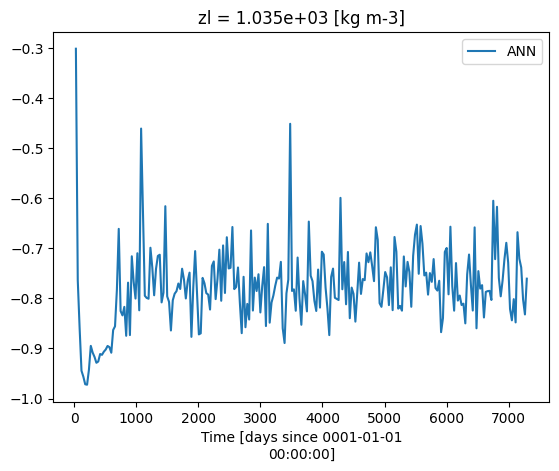

In [94]:
xr.corr(Esource_adv, Esource_ZB, ['xh', 'yh']).isel(zl=0).plot(label='ANN')
#xr.corr(Esource_adv, Esource_ZB+Esource_smag, ['xh', 'yh']).isel(zl=0).plot(label='ANN+Smag')
plt.legend()